In [93]:
%run modulo-adder.ipynb
%run modulo-multiplier.ipynb

done
done


In [94]:
# returns gcd(a,N) = ax + Ny as (gcd, x, y)
# returns (a, 0, 1) if N divides a
# a must be larger than N
def linear_comb_gcd(N, a):
    assert a < N
    euc_rows = [
        (N, 1, 0),
        (a, 0, 1)
    ]
    # apply extended Euclidean algorithm
    i = 1
    next_row = (a, 0, 1)
    while next_row[0] != 0:
        r = int(euc_rows[i-1][0] % euc_rows[i][0]) # remainder of division
        c = int((euc_rows[i-1][0] - r) / euc_rows[i][0]) # coefficient to multiply row by
        next_row = (
            euc_rows[i-1][0] - c * euc_rows[i][0],
            euc_rows[i-1][1] - c * euc_rows[i][1],
            euc_rows[i-1][2] - c * euc_rows[i][2]
        )
        euc_rows += [next_row]
        i += 1
    return euc_rows[i-1]

In [95]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import QFT
from math import log, ceil, floor, pi

def c_U(a, N, n_x_qubits, n_b_qubits):
    cU_circ = QuantumCircuit(
        QuantumRegister(1, name="control"),
        QuantumRegister(n_x_qubits, name="x"),
        QuantumRegister(n_b_qubits, name="b"),
        QuantumRegister(1, name="ancilla")
    )
    cU_circ.append(
        c_mod_mul(a, N, n_x_qubits, n_b_qubits).to_gate(label=f"CMUL({a})MOD({N})"),
        range(1 + n_x_qubits + n_b_qubits + 1)
    )
    for i in range(n_x_qubits):
        cU_circ.swap(i+1, n_x_qubits + i+1)
    #cU_circ.append(swap_circuit(n_x_qubits + n_b_qubits).to_gate(label=f"SWAP"), range(1, n_x_qubits + n_b_qubits + 1))
    a_inv = linear_comb_gcd(N, a)[2]
    if (a_inv < 0):
        a_inv = -a_inv
    cU_circ.append(
        c_mod_mul(a_inv, N, n_x_qubits, n_b_qubits).inverse().to_gate(label=f"CMUL({a_inv})MOD({N})"),
        range(1 + n_x_qubits + n_b_qubits + 1)
    )
    return cU_circ

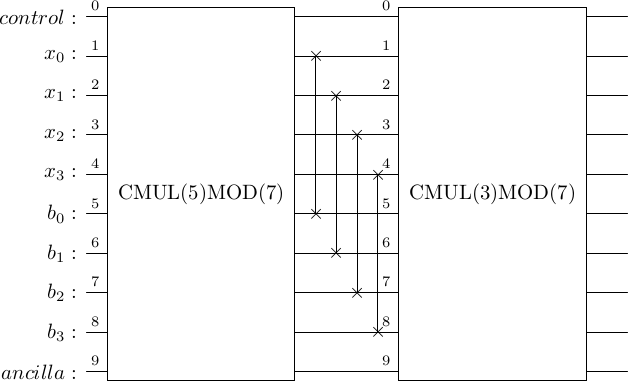

In [97]:
a = 5
x = 4
b = 0
N = 7
n_req = floor(log(N, 2)) + 1
n_qubits = n_req + 1
n_b_qubits = n_qubits

c_U(a, N, x, n_b_qubits).draw("latex")

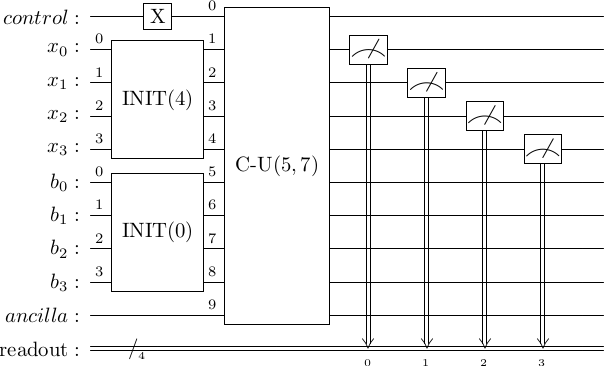

In [107]:
a = 5
x = 4
b = 0
N = 7
n_req = floor(log(N, 2)) + 1
n_qubits = n_req + 1
n_b_qubits = n_qubits

test_circ = QuantumCircuit(
    QuantumRegister(1, name="control"),
    QuantumRegister(n_b_qubits, name="x"),
    QuantumRegister(n_b_qubits, name="b"),
    QuantumRegister(1, name="ancilla"),
    ClassicalRegister(n_b_qubits, name="readout")
)
test_circ.x(0)
test_circ.append(
    init_x_circuit(x, n_b_qubits, msb_top=False).to_gate(label=f"INIT({x})"), 
    [i + 1 for i in range(n_b_qubits)]
)
test_circ.append(
    init_x_circuit(b, n_b_qubits, msb_top=False).to_gate(label=f"INIT({b})"),
    [i + 1 + n_b_qubits for i in range(n_b_qubits)]
)
test_circ.append(
    c_U(a, N, x, n_b_qubits).to_gate(label=f"C-U({a},{N})"),
    range(1 + n_b_qubits + n_b_qubits + 1)
)
measure_qubits = []
test_circ.measure(range(1, 1 + n_b_qubits), range(0, n_b_qubits))
test_circ.draw("latex")

In [104]:
from qiskit.providers.aer import QasmSimulator
from qiskit import transpile

""" Simulation """
# Create a simulator
simulator = QasmSimulator()
# Compile the circuit for the simulator
compiled_circuit = transpile(test_circ, simulator)
# Simulate the circuit
simulation = simulator.run(compiled_circuit, shots=1)
# Get the simulation results
simulation_result = simulation.result()
counts = simulation_result.get_counts(compiled_circuit)
counts

{'0110': 1}

In [105]:
test2 = QuantumCircuit(
    QuantumRegister(1, name="control"),
    QuantumRegister(n_x_qubits, name="x"),
    QuantumRegister(n_b_qubits, name="b"),
    QuantumRegister(1, name="ancilla"),
    ClassicalRegister(n_x_qubits, name="readout")
)
test2.x(0)
test2.append(
    init_x_circuit(x, n_x_qubits, msb_top=False).to_gate(label=f"INIT({x})"), 
    [i + 1 for i in range(n_x_qubits)]
)
test2.append(
    init_x_circuit(b, n_b_qubits, msb_top=False).to_gate(label=f"INIT({b})"),
    [i + 1 + n_x_qubits for i in range(n_b_qubits)]
)
test2.append(
    c_mod_mul(a, N, n_x_qubits, n_b_qubits).to_gate(label=f"CMUL({a})MOD({N})"),
    range(1 + n_x_qubits + n_b_qubits + 1)
)
for i in range(n_x_qubits):
    test2.swap(i+1, n_x_qubits + i+1)
test2.measure(range(1, 1 + n_x_qubits), range(0, n_b_qubits))
"""
#cU_circ.append(swap_circuit(n_x_qubits + n_b_qubits).to_gate(label=f"SWAP"), range(1, n_x_qubits + n_b_qubits + 1))
a_inv = linear_comb_gcd(N, a)[2]
if (a_inv < 0):
    a_inv = -a_inv
test2.append(
    c_mod_mul(a_inv, N, n_x_qubits, n_b_qubits).inverse().to_gate(label=f"CMUL({a_inv})MOD({N})"),
    range(1 + n_x_qubits + n_b_qubits + 1)
)
"""
test2.draw("latex")

CircuitError: 'The amount of qubit(9)/clbit(0) arguments does not match the gate expectation (10).'

In [87]:
""" Simulation """
# Create a simulator
simulator = QasmSimulator()
# Compile the circuit for the simulator
compiled_circuit = transpile(test2, simulator)
# Simulate the circuit
simulation = simulator.run(compiled_circuit, shots=1)
# Get the simulation results
simulation_result = simulation.result()
counts = simulation_result.get_counts(compiled_circuit)
counts

{'0100110101': 1}